<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# [CS4740 Labs] Week 7: Convolutional Neural Networks

##Introduction

In this lab we will look at 

In [1]:
!pip install gym > /dev/null 2>&1
!apt install swig cmake > /dev/null 2>&1
!pip install box2d box2d-kengz > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# To activate virtual display 
# need to run a script once for training an agent as follows
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
from random import random,choice

In [104]:
def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return choice(np.arange(env.action_space.n))

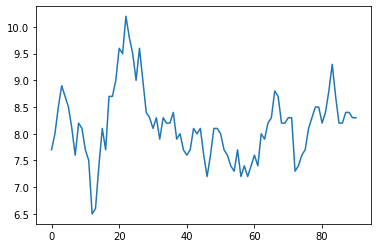

In [60]:
alpha = 0.5
gamma = 0.6
epsilon = 1

env = gym.make('Taxi-v3')

from collections import defaultdict
from random import random

# Q = defaultdict(lambda: np.zeros(env.action_space.n))
frames,rewards=[],[]
num_of_episodes = 100
# num_of_episodes = 2000
for e in range(num_of_episodes):
    # epsilon = max(0.01, 0.990*epsilon)
    epsilon = 0.0
    S = env.reset()
    done=False
    totalR=0
    while not done:
        A = env.action_space.sample() if random()<epsilon else Q[S].argmax()
        S_new, R, done, _ = env.step(A)
        totalR += R
        if done:
            target = R
        else:
            target = R + gamma * Q[S_new].max()
        Q[S][A] += alpha * (target-Q[S][A])
        S = S_new
        frames.append(env.render(mode='ansi'))
    rewards.append(totalR)
env.close()

rewards=np.array(rewards)
avg_rewards = np.convolve(rewards, [0.1]*10,mode='valid')
plt.plot(avg_rewards,'-')

In [63]:
from IPython.display import clear_output
from time import sleep

for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(frame['frame'])
    sleep(.2)

+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



KeyboardInterrupt: ignored

In [ ]:
env = Monitor(gym.make('LunarLander-v2'),directory='./video',force=True)

In [ ]:
env.action_space.

At each step, the agent is provided with the current state of the space vehicle which is an 8-dimensional vector of real values, indicating the horizontal and vertical positions, orientation, linear and angular velocities, state of each landing leg (left and right). The agent then has to make one of four possible actions, namely do nothing, fire left orientation engine, fire main engine, or fire right orientation engine. These are 4 levers the agent must learn to control in order to land safely.

In [ ]:
s = env.reset()
done=False
while not done:
    a = env.action_space.sample()
    s,r,done,_=env.step(a)

env.close()

In [ ]:
class MLPnet(nn.Module):
    def __init__(self, *sizes):
        self.num_actions = sizes[-1]
        super(MLPnet, self).__init__()
        self.layers = nn.ModuleList()
        for s,s_ in zip(sizes[:-1],sizes[1:]):
            self.layers.append(nn.Linear(s,s_))
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [ ]:
class TorchWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return torch.tensor(observation, device=device, dtype=torch.float)

In [ ]:
def epsilon_greedy(epsilon, S, qnet, env):
    if random() < epsilon:
        return env.action_space.sample()
    else:
        return qnet(S).argmax().item()

In [ ]:
def sample(data, batchsize):
    import random
    size = min(len(data),batchsize)
    return random.sample(data, size)

In [ ]:
def updateQNet(qvalue, target, optimiser, loss):
    L = loss(qvalue, target)
    optimiser.zero_grad()
    L.backward()
    optimiser.step()

In [ ]:
from collections import deque
from random import random,sample

In [ ]:
env = TorchWrapper(Monitor(gym.make('LunarLander-v2'),directory='./video',force=True,video_callable=lambda i:i%10==0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


epsilon = 0.4
rewards=[]
gamma = 0.99
num_episodes=1000
num_actions = env.action_space.n
state_size = env.observation_space.shape[0]
batchsize=64


qnet = MLPnet(state_size,64,64,32,num_actions)
optim = torch.optim.Adam(qnet.parameters(), lr= 0.1)
loss = nn.MSELoss()

for e in range(num_episodes):
    done = False
    S = env.reset()
    tot_reward=0

    epsilon = max(0.1, epsilon*0.99)
    while not done:
        A = epsilon_greedy(epsilon, S, qnet, env) 
        S_new, R, done, _ = env.step(A)

        R = torch.tensor(R,device=device, dtype=torch.float)

        if done:
            target = R
        else:
            target = R + gamma * qnet(S_new).max()
        qvalue = qnet(S)[A]
        updateQNet(qvalue, target,optim,loss)

        tot_reward += R
        S = S_new
        
    rewards.append(tot_reward)
    print(f"\r{e}/{num_episodes} tot_reward={tot_reward}",end='')


# print(f"Average reward:{sum(rewards[-50:])/50}")
# return rewards, replaybuffer

In [ ]:
def updateQNet_batch(qnet, batch, optimizer, loss):
    s,a,r,s_new,d = batch
    
    s=torch.stack(s)
    s_new=torch.stack(s_new)
    r=torch.tensor(r,device=device,dtype=torch.float)
    d=torch.tensor(d,device=device,dtype=torch.bool)
    a=torch.tensor(a,device=device,dtype=torch.int64)

    with torch.no_grad():
        qmax,_ = qnet(s_new).view(-1,num_actions).max(dim=1)
        target = torch.where(d, r, r + gamma * qmax).view(-1,1)
    L = loss(qnet(s).gather(1,a.view(-1,1)),target)
    optim.zero_grad()
    L.backward()
    optim.step()

In [ ]:
env = TorchWrapper(Monitor(gym.make('LunarLander-v2'),directory='./video',force=True,video_callable=lambda i:i%10==0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


epsilon = 1
rewards=[]
gamma = 0.99
num_episodes=1000
num_actions = env.action_space.n
state_size = env.observation_space.shape[0]
batchsize=64

replaybuffer = deque(maxlen=100000)


qnet = MLPnet(state_size,64,64,32,num_actions)
optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)
loss = nn.MSELoss()

for e in range(num_episodes):
    done = False
    S = env.reset()
    tot_reward=0

    epsilon = max(0.1, epsilon*0.99)
    while not done:
        A = epsilon_greedy(epsilon, S, qnet, env) 
        S_new, R, done, _ = env.step(A)
        replaybuffer.append((S,A,R,S_new,done))

        tot_reward += R
        S = S_new
        batch = sample(replaybuffer,batchsize)
        batch = zip(*batch)
        
        updateQNet_batch(qnet, batch, optimizer, loss)
    rewards.append(tot_reward)
    print(f"\r{e}/{num_episodes} tot_reward={tot_reward}",end='')


# print(f"Average reward:{sum(rewards[-50:])/50}")
# return rewards, replaybuffer